# Time Series Learning: ARIMA, RNN, LSTM practice  
This colab is an introduction to data prediction using Recurrent Neural Networks (RNNs). In this lab, we will work with a cosine signal data. This lab covers four types of RNN.
* Simple ARIMA
* Simple RNN: Fully-connected RNN where the output is to be fed back to input.
* Long Short-Term Memory (LSTM)
* Bidirectional Long Short-Term Memory (Bi-LSTM)
* Gated Recurrent Unit (GRU)







## Generating a cosine signal data


In [ ]:
import numpy as np
import pandas as pd 
import plotly.graph_objects as go

MINUTE = 60

Fs = 1  # sampling frequency (Hz)
T = MINUTE*30   # time duration 

t = np.arange(0, T, 1/Fs)  # the time samples
f=0.01 # signal 0.01 hz 
signal = np.cos(2*np.pi*f*t)*np.random.normal(1, 0.2, len(t))
#signal = np.cos(2*np.pi*f*t) #+ np.random.normal(0, 0.2, len(t))

# in this example, 30*60 = 1800 samples 

# Generating a Pandas dataframe with signal as data and t as index 
dataset = pd.DataFrame(data={'time': t, 'signal': signal})
dataset.set_index('time', inplace=True)

In [ ]:
sample_length_in_minute = 30 #@param {type:"slider", min:0, max:30, step:10}

sample = dataset[dataset.index < sample_length_in_minute*MINUTE]

# Show the signal over t
fig = go.Figure(go.Scatter(x=sample.index, y=sample.signal, mode='lines'))
fig.show()

## Choose a length of the input data
Before building our RNN models, we first need to choose the length of a input data (i.e., x data) that will be fed to a RNN network). In this tutorial, we will call the input data length as HISTORY_SIZE. We can also set the length of a output data (i.e., y data). In this tutorial, we will call the output length as TARGET_SIZE. For simplicity, we alway set TARGET_SIZE as 1. Accodring to HISTORY_SIZE, the below graph shows x and y data. The x is an input data, Whereas, the y is the expected output dataput. Don't forget to execute this cell to visualize x and y data. 




In [ ]:
import numpy as np
import plotly.graph_objects as go
import pandas as pd 

def plot_data_instance(x1, y1, x2, y2):
  fig = go.Figure(go.Scatter(x=x1, y=y1, mode='lines+markers', name='x', marker={'size': 10, 'color': 'blue'}))
  fig.add_trace(go.Scatter(x=x2, y=y2, mode='markers', name='y', marker={'size': 10, 'color': 'red'}))
  fig.update_layout(
      xaxis=dict(
          showline=True,
          showgrid=False,
          showticklabels=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=2,
          ticks='outside',
          tickfont=dict(
              family='Arial',
              size=12,
              color='rgb(82, 82, 82)',
          ),
      ),
      yaxis=dict(
          showline=True,
          showgrid=False,
          showticklabels=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=2,
          ticks='outside',
          tickfont=dict(
              family='Arial',
              size=12,
              color='rgb(82, 82, 82)',
          ),
      ),
      showlegend=True,
      plot_bgcolor='white'
  )
  fig.show()

HISTORY_SIZE = 40 #@param {type:"slider", min:20, max:600, step:20}

TARGET_SIZE = 1

# get n singal values (e.g., n = 60, value range = 0 ~ <60 second)
x = dataset[dataset.index < HISTORY_SIZE/Fs]
# get the (n + 1)th singal value (e.g, n = 60, value at 60 second) 
y = dataset[(HISTORY_SIZE/Fs <= dataset.index) & (dataset.index < (HISTORY_SIZE+TARGET_SIZE)/Fs)]

plot_data_instance(x.index, x.signal, y.index, y.signal)

## Generating train and test set
According to HISTORY_SIZE and TARGET_SIZE, we generate train and test set by splitting our dataset according to TEST_SPLIT_RATIO. The TEST_SPLIT_RATIO represent a ratio between test and tain sets. For example, when TEST_SPLIT_RATIO is 0.1, 90% of data will be assinged as train set, whereas 10% of the whole will be assinged as test set. 






In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def split_into_train_and_test_set_arima(data, test_split, history_size, target_size, y_column = None, seed = 17):
  assert 0 <= test_split < 1 
  if y_column is not None:
    assert y_column in data.columns
 
  values = data.to_numpy(copy=True) # Make a copy and convert to a NumPy array

  # Split into training and test set  
  train_length = int(len(values)*(1 - test_split)) # calculate size of train set
  train = values[:train_length]
  x_train = np.arange(0, train_length) 

  test = values[train_length:]
  x_test = np.arange(train_length, len(values))  
  
  # normalize data (see below for detailed description)
  scaler = MinMaxScaler(feature_range=(train.min(), train.max()))

  y_train = scaler.fit_transform(train)
  y_train = y_train.flatten() 
  y_test = scaler.fit_transform(test)
  y_test = y_test.flatten() 

  return (x_train, y_train), (x_test, y_test)

# Define a method that returns train and test sets. 
def split_into_train_and_test_set(data, test_split, history_size, target_size, y_column = None, seed = 17, doShuffle = True):
  assert data is not None
  assert 0 <= test_split < 1
  assert 1 <= history_size 
  assert 1 <= target_size 

  if y_column is not None:
    assert y_column in data.columns

  np.random.seed(seed)  # Set seed for random fuction.

  values = data.to_numpy(copy=True) # Make a copy and convert to a NumPy array

  # Split into training and test set  
  train_length = int(len(values)*(1 - test_split)) # calculate size of train set
  train = values[:train_length]
  test = values[train_length:]
  
  # Normalize dataset
  # It is important to normalize data before feeding to a neural network. 
  # A common way to do so is by subtracting the mean and dividing by the standard deviation of each feature.
  # The mean and standard deviation should only be computed using the training data. 
  # For the normalization, we use min-max normalization using MinMaxScaler method.
  # Alternative way to do min-max normalization
  # train = (train-train_min)/(train_max-train_min)
  # test = (test-train_min)/(train_max-train_min)
  # evaluation = (evaluation-train_min)/(train_max-train_min)
  
  scaler = MinMaxScaler(feature_range=(train.min(), train.max()))
  train = scaler.fit_transform(train)
  test = scaler.fit_transform(test)
 
  # get x, y data for training and test set
  y_column_index = 0 if y_column == None else list(data.columns).index(y_column)  

  #print("y_column_index:  ", y_column_index)

  x_train, y_train = get_x_y_data(train, y_column_index, history_size, target_size, doShuffle)
  x_test, y_test = get_x_y_data(test, y_column_index, history_size, target_size)
  return (x_train, y_train), (x_test, y_test)

def get_x_y_data(data, column_index, history_size, target_size, doShuffle = False):
  # calculate an array containing the start index of each x data
  start_index_array = np.arange(0, len(data) - target_size - history_size)

  #print("start_index_arry:", start_index_array)

  # We shuffle ONLY "the order of start index".
  # This means we don't shuffle the ordering within individual sequences, but shuffle the order in which sequences are fed to the RNN
  #
  # This is fine when your network is stateless. 
  # On the other hand, when your network is stateful, a different shuffle strategy is necessary. 
  #   
  # Stateless case: 
  # the network's memory only persists for the duration of a sequence. 
  # Training on sequence B before sequence A doesn't matter because the network's memory state does not persist across sequences.
  #
  # Stateful case:
  # The network's memory persists across sequences. We cannot blindly shuffle your data and expect optimal results. 
  # Sequence A should be fed to the network before sequence B because we want the network to evaluate sequence B with memory of what was in sequence A.
  #
  # Philippe Remy wrote a nice tutorial, see if you are curious to know how to suffle training set for stateful RNN
  # http://philipperemy.github.io/keras-stateful-lstm/
  if doShuffle:
    np.random.shuffle(start_index_array)  # shuffle the start_index_array
  
  # initialize x, y array - the output of this method
  x = []
  y = []
  
  for i in start_index_array:

    # Add a data instance (history data) that will be fed to your network, into x array
    # range(i, i+history_size) returns an indices_array (e.g., [i, i+1, i+2, .. , i+history_size] ) that beloing to the data instance
    # dataset[range(i, i+history_size)] return a array that data points corresponding to the indices in the indices_array
    x.append(data[range(i, i+history_size)])

     # add a y (ground truth value) into y array
    y.append(data[i+history_size] if data.shape[-1:] == 1 else data[i+history_size][column_index])
  
  return np.array(x), np.array(y)

In [ ]:
TEST_SPLIT_RATIO = 0.2 #@param {type:"slider", min:0.1, max:0.9, step:0.1}

In [ ]:
(x_train, y_train), (x_test, y_test)= split_into_train_and_test_set(dataset, TEST_SPLIT_RATIO, HISTORY_SIZE, TARGET_SIZE)
(x_train_arima, y_train_arima), (x_test_arima, y_test_arima)= split_into_train_and_test_set_arima(dataset, TEST_SPLIT_RATIO, HISTORY_SIZE, TARGET_SIZE)

Let's see how the train and test dataset look like by plotting a graph (for RNNs). First set which instance in which dataset (train vs. test set) to visualize, then run the next cell.

In [ ]:
#@title
import plotly.graph_objects as go
import numpy as np
import ipywidgets as widgets

# A checkBox for selecting which data (e.g, train vs. test) to visualize
isTrain_checkBox = widgets.Checkbox(value=True, description='Check for training set')

# Define a method (or lambda expression) return train or test set depending on the checkBox value (or checkbox selection) (i.e., if check return train set)
get_data = lambda train, test : train if isTrain_checkBox.value else test

# Initialize slider for selecting which instance to visualize
get_max_size = lambda : len(get_data(x_train, x_test))
get_range_label = lambda : "Which data instance (range = 0-{}) ?".format(get_max_size())
instance_no_slider = widgets.IntSlider(value=0, max=get_max_size())

# A label showing instance range 
slider_max_label = widgets.Label()

# Define a method that updates instance range 
def resetIstanceNoSlider(change):
  slider_max_label.value = get_range_label()
  instance_no_slider.max = get_max_size()
  instance_no_slider.value = 0
resetIstanceNoSlider(True)

# Setup isTrain_checkBox to call 'resetIstanceNoSlider method' when the checkBox value is changed
isTrain_checkBox.observe(resetIstanceNoSlider, names='value')

# Display all components
display(widgets.HBox([widgets.Label(value="Which dataset ?"), isTrain_checkBox, slider_max_label, instance_no_slider]))

In [ ]:
# Plot a graph
instance_no = instance_no_slider.value
data_x = np.squeeze(get_data(x_train, x_test)[instance_no])
t = np.arange(0, len(data_x)/Fs, 1/Fs)

# plot_data_instance(x1, y1, x2, y2):
plot_data_instance(t, np.squeeze(data_x), t[-1:]+1/Fs, [get_data(y_train, y_test)[instance_no]])

## Build ARIMA models
Let's first fit an ARIMA model. You can take a look at the details about how to use the ARIMA model in [this blog article](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/). Another good example: [HTML](https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c)

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.1MB 3.4MB/s 


We'll use "auto_arima" which automatically finds the parameters: p, q, d. 

BTW, Pmdarima (originally pyramid-arima, for the anagram of 'py' + 'arima') is a no-nonsense statistical Python library with a solitary objective: bring R's auto.arima functionality to Python. Pmdarima operates by wrapping statsmodels.tsa.ARIMA and statsmodels.tsa.statespace.SARIMAX into one estimator class and creating a more user-friendly estimator interface for programmers familiar with scikit-learn. For more details, please read [this article](https://www.alkaline-ml.com/pmdarima/about.html). 

Fit ARIMA: order=(1, 0, 1); AIC=-838.458, BIC=-816.898, Fit time=0.320 seconds
Fit ARIMA: order=(0, 0, 0); AIC=3523.202, BIC=3533.982, Fit time=0.002 seconds
Fit ARIMA: order=(1, 0, 0); AIC=-500.146, BIC=-483.975, Fit time=0.026 seconds
Fit ARIMA: order=(0, 0, 1); AIC=2088.585, BIC=2104.756, Fit time=0.046 seconds
Fit ARIMA: order=(2, 0, 1); AIC=-875.559, BIC=-848.608, Fit time=0.295 seconds
Fit ARIMA: order=(2, 0, 0); AIC=-852.882, BIC=-831.321, Fit time=0.063 seconds
Fit ARIMA: order=(2, 0, 2); AIC=-1575.142, BIC=-1542.801, Fit time=5.821 seconds
Fit ARIMA: order=(3, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2); AIC=-890.255, BIC=-863.304, Fit time=0.306 seconds
Fit ARIMA: order=(3, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 7.300 seconds


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1620
Model:                     ARMA(2, 2)   Log Likelihood                 793.571
Method:                       css-mle   S.D. of innovations              0.148
Date:                Tue, 19 Nov 2019   AIC                          -1575.142
Time:                        02:37:46   BIC                          -1542.801
Sample:                             0   HQIC                         -1563.140
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.007      0.167      0.868      -0.012       0.014
ar.L1.y        1.9952        nan        nan        nan         nan         nan
ar.L2.y       -0.9991        nan        nan        n

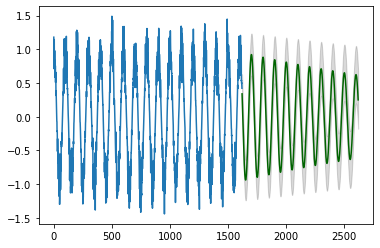

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima.arima.utils import ndiffs

#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

df = pd.DataFrame(data={'time': x_train_arima, 'value': y_train_arima})
#df = pd.DataFrame(data={'time': x_train[1:150], 'value': y_train[1:150]})
df.set_index('time', inplace=True)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # Yes, Seasonality
                      start_P=0, 
                      D=None,  # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

# Forecast
n_periods = 1000
#n_periods = len(x_test)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
 
plt.show()

## Build RNN models
We build four RNN models - simple RNN, LSTM, and GRU models. Here's a simple structure of an RNN model: ![alt text](https://i.stack.imgur.com/qXjnM.png); the unit size represents the number of neurons to be used in an RNN cell.

In [ ]:
import tensorflow as tf
EPOCHS = 40 #@param {type:"slider", min:5, max:300, step:5}
BATCH_SIZE = 1400 #@param {type:"slider", min:10, max:1400, step:10}
unit_size = int(HISTORY_SIZE*4/5)

# Note that in Keras, the default value for any dropout is zero while you can set the value upto 1.0 
RNN_INPUT_DROPOUT_RATE = 0 #@param {type:"slider", min:0, max:0.5, step:0.1}
RECURRENT_DROPOUT_RATE = 0 #@param {type:"slider", min:0, max:0.5, step:0.1}
DROPOUT_RATE_AFTER_RNN = 0.3 #@param {type:"slider", min:0, max:0.5, step:0.1}

### RNN model

In [ ]:
# Built a simple RNN model
simple_RNN_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(unit_size, input_shape=(None, 1), recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE),
    tf.keras.layers.Dropout(DROPOUT_RATE_AFTER_RNN),
    tf.keras.layers.Dense(TARGET_SIZE) # TARGET_SIZE 1 
])

# We used mean squared error (mse) for the lost function and Adam for the optimizer. 
# We can also use other types of lost function, as well as optimizer.    
# If you are curious about these optimizer and loss funtion, please see followings
# loss funtion: https://medium.com/deep-learning-demystified/loss-functions-explained-3098e8ff2b27
# optimizer: https://medium.com/deep-learning-demystified/https-medium-com-deep-learning-demystified-understanding-optimizers-313b787a69fe
simple_RNN_model.compile(optimizer='adam', loss='mse')
simple_RNN_model.summary()

# Train the model
simple_RNN_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 32)                1088      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
Train on 1579 samples, validate on 139 samples
Epoch 1/40
1579/1579 [==============================] - 0s 253us/sample - loss: 0.3923 - val_loss: 0.1949
Epoch 2/40
1579/1579 [==============================] - 0s 32us/sample - loss: 0.2381 - val_loss: 0.1138
Epoch 3/40
1579/1579 [==============================] - 0s 31us/sample - loss: 0.1655 - val_loss: 0.0713
Epoch 4/40
1579/157

### LSTM model

In [ ]:
# Built a simple LSTM model
simple_LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(unit_size, input_shape=(None, 1), recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE),
    tf.keras.layers.Dropout(DROPOUT_RATE_AFTER_RNN),
    tf.keras.layers.Dense(TARGET_SIZE)
])

simple_LSTM_model.compile(optimizer='adam', loss='mse')
simple_LSTM_model.summary()

# Train the model
simple_LSTM_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1579 samples, validate on 139 samples
Epoch 1/40
1579/1579 [==============================] - 1s 557us/sample - loss: 0.4515 - val_loss: 0.4060
Epoch 2/40
1579/1579 [==============================] - 0s 136us/sample - loss: 0.4037 - val_loss: 0.3663
Epoch 3/40
1579/1579 [=======

### GRU model

In [ ]:
# Built a simple GRU model
simple_GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(unit_size, input_shape=(None, 1), recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE),
    tf.keras.layers.Dropout(DROPOUT_RATE_AFTER_RNN),
    tf.keras.layers.Dense(TARGET_SIZE)
])
simple_GRU_model.compile(optimizer='adam', loss='mse')
simple_GRU_model.summary()

# Train the model
simple_GRU_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3264      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________
Train on 1579 samples, validate on 139 samples
Epoch 1/40
1579/1579 [==============================] - 1s 864us/sample - loss: 0.3902 - val_loss: 0.3565
Epoch 2/40
1579/1579 [==============================] - 0s 125us/sample - loss: 0.3547 - val_loss: 0.3203
Epoch 3/40
1579/1579 [==============================] - 0s 130us/sample - loss: 0.3126 - val_loss: 0.2854
Epoch 4/40
1579/1

### Comparing prediction results
Let's see how the four types of models predicting our testset. Please note that any difference in EPOCHS, BATCH_SIZE, RNN_INPUT_DROPOUT_RATE, RECURRENT_DROPOUT_RATE, or DROPOUT_RATE_AFTER_RNN can make hugh improvements on the predictive performances of the models. Please try with different values for EPOCHS, BATCH_SIZE, RNN_INPUT_DROPOUT_RATE, RECURRENT_DROPOUT_RATE, or DROPOUT_RATE_AFTER_RNN, and see how the preformance changes.

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Return predicted valued using the input prediction model and x 
def getPredictedValues(model, x):
  result = np.zeros((len(x),1))
  for i in range(0, len(x)):
    data = x[i]
    result[i] = model.predict(np.array([data]), batch_size=1)
  return np.squeeze(result)

# Plot graphs
def plot_prediction_results(x, y, name, *args):
  assert x is not None
  assert y is not None
  assert name is not None and 0 < len(name)
  assert len(args)%2 == 0

  fig = go.Figure(go.Scatter(x=x, y=y, mode='lines', name=name))
  for i in range(0, len(args), 2):
    fig.add_trace(go.Scatter(x=x, y=args[i], mode='markers', name=args[i+1]))

  fig.update_layout(
      xaxis=dict(
          showline=True,
          showgrid=False,
          showticklabels=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=2,
          ticks='outside',
          tickfont=dict(
              family='Arial',
              size=12,
              color='rgb(82, 82, 82)',
          ),
      ),
      yaxis=dict(
          showline=True,
          showgrid=False,
          showticklabels=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=2,
          ticks='outside',
          tickfont=dict(
              family='Arial',
              size=12,
              color='rgb(82, 82, 82)',
          ),
      ),
      showlegend=True,
      plot_bgcolor='white')
  fig.show()

t = np.arange(0, len(x_test)/Fs, 1/Fs)
plot_prediction_results(t, 
                        np.squeeze(y_test), 'Expected', 
                        getPredictedValues(simple_RNN_model, x_test), 'RNN', 
                        getPredictedValues(simple_LSTM_model, x_test), 'LSTM',
                        getPredictedValues(simple_GRU_model, x_test), 'GRU')



## Build advanced RRN models
We can also build more advanced RNN models (e.g., an RNN model with multiple LSTM layes). We will learn how to add more layers 

### Bidirectional LSTM model

In [ ]:
# Built a simple Bidirectiona-LSTM model
# Whem compare to the simple LSTM model, we put the LSTM layer inside tf.keras.layers.Bidirectional() and replace the input_shape parameter to the outside of the layer
simple_BiLSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(unit_size, recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE), input_shape=(None, 1)),
    tf.keras.layers.Dropout(DROPOUT_RATE_AFTER_RNN),
    tf.keras.layers.Dense(TARGET_SIZE)
])

simple_BiLSTM_model.compile(optimizer='adam', loss='mse')
simple_BiLSTM_model.summary()

# Train the model
simple_BiLSTM_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 64)                8704      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________
Train on 1579 samples, valid

### Stacked LSTM model

In [ ]:
import tensorflow as tf

# Built a stacked LSTM model
complex_LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(unit_size, input_shape=(None, 1), recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE, return_sequences = True),
    tf.keras.layers.LSTM(unit_size, recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE, return_sequences = True),
    tf.keras.layers.LSTM(unit_size, recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE, return_sequences = True),
    tf.keras.layers.LSTM(unit_size, recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE, return_sequences = False),
    tf.keras.layers.Dropout(DROPOUT_RATE_AFTER_RNN),
    tf.keras.layers.Dense(TARGET_SIZE)
])

complex_LSTM_model.compile(optimizer='adam', loss='mse')
complex_LSTM_model.summary()

# Train the model
complex_LSTM_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 32)          4352      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
__________________________________________________

Stateful LSTM

In [ ]:
# Built a stateful LSTM model
# Note that for the parameter for LSTM layer, we have two additional parameters (1) 'stateful=True' and (2) 'batch_size = 1' while remaining are the same.
# Not suprisingly, 'stateful=True' is the magic parameter that changes stateless LSTM to stategul LSTM.  
# Next, we specify the batch size of your inputs (e.g, training set) . 
# For a stateful network, inputs must be multple of the batch size. In other words, you should be able to divide the size of inputs with the batch size
# In this tutorial, for simplicity, we set batch_size as 1 (i.e., batch_size = 1)

stateful_LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(unit_size, stateful=True, batch_size = 1, input_shape=(None, 1), recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE),
    tf.keras.layers.Dropout(DROPOUT_RATE_AFTER_RNN),
    tf.keras.layers.Dense(TARGET_SIZE)
])

stateful_LSTM_model.compile(optimizer='adam', loss='mse')
stateful_LSTM_model.summary()

# As discussed alreay, we can not blindly shuffle testset, since the stateful network use the information of previou input to predict next input.     
# For simplicity, we do not shuffule a training set.
(not_shuffled_x_train, not_shuffled_y_train), _ = split_into_train_and_test_set(dataset, TEST_SPLIT_RATIO, HISTORY_SIZE, TARGET_SIZE, doShuffle=False)

stateful_LSTM_model.fit(not_shuffled_x_train, not_shuffled_y_train, epochs=1, batch_size=1, shuffle=False , validation_data=(x_test, y_test))

# For performance evaluation, do similar as follows
# Since stateful network remember all the previous inputs, we need to reset_state after every epoch
# for i in range(EPOCHS):
#   stateful_LSTM_model.fit(not_shuffled_x_train, not_shuffled_y_train, epochs=1, batch_size=1, shuffle=False , validation_data=(x_test, y_test))
#   stateful_LSTM_model.reset_states()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (1, 32)                   4352      
_________________________________________________________________
dropout_5 (Dropout)          (1, 32)                   0         
_________________________________________________________________
dense_5 (Dense)              (1, 1)                    33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Train on 1579 samples, validate on 139 samples
1579/1579 [==============================] - 29s 19ms/sample - loss: 0.0712 - val_loss: 0.0253


### Comparing prediction results

In [ ]:
plot_prediction_results(t, 
                        np.squeeze(y_test), 'Expected', 
                        getPredictedValues(simple_LSTM_model, x_test), 'Simple-LSTM',
                        getPredictedValues(simple_BiLSTM_model, x_test), 'Bi-LSTM',
                        getPredictedValues(complex_LSTM_model, x_test), 'Stacked-LSTM',
                        getPredictedValues(stateful_LSTM_model, x_test), 'Stateful-LSTM')

# Homework
For the homework, we uses a [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the [Max-Planck-Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/index.php/Main/HomePage). The dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. **For efficiency, you will use only the 'temperature data' collected 'between 2009 and 2016'**. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [17]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf

def load_weather_data():
  zip_path = tf.keras.utils.get_file(
      origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
      fname='jena_climate_2009_2016.csv.zip',
      extract=True)
  csv_path, _ = os.path.splitext(zip_path)
  df = pd.read_csv(csv_path)
  df = df['T (degC)']
  return df

weather_data = load_weather_data()

In [42]:
weather_df = pd.DataFrame(weather_data)
weather_df[:10000]
# Data is too many, so I will use 10000 data

,T (degC)
0,-8.02
1,-8.41
2,-8.51
3,-8.31
4,-8.27
...,...
9995,2.69
9996,2.98
9997,3.66
9998,4.21


# Q1
Q1: Please build 3 types of RNN models (LSTM, Bi-LSTM, GRU) that predict a future temperature (TARGET_SIZE = 1) based on last 8 temperatures (HISTORY_SIZE = 8). For training, please use 90% of the data (TEST_SPLIT_RATIO = 0.1). You can still build simple RNN models, but are welcome to come out with more complicated models (e.g, bi-). 


#### dataset

In [31]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def split_into_train_and_test_set(data, test_split, history_size, target_size, y_column = None, seed = 17, doShuffle = True):
  assert data is not None
  assert 0 <= test_split < 1
  assert 1 <= history_size 
  assert 1 <= target_size 

  if y_column is not None:
    assert y_column in data.columns

  np.random.seed(seed)  # Set seed for random fuction.

  values = data.to_numpy(copy=True) # Make a copy and convert to a NumPy array

  # Split into training and test set  
  train_length = int(len(values)*(1 - test_split)) # calculate size of train set
  train = values[:train_length]
  test = values[train_length:]
  
  scaler = MinMaxScaler(feature_range=(train.min(), train.max()))
  train = scaler.fit_transform(train)
  test = scaler.fit_transform(test)
 
  # get x, y data for training and test set
  y_column_index = 0 if y_column == None else list(data.columns).index(y_column)  

  #print("y_column_index:  ", y_column_index)

  x_train, y_train = get_x_y_data(train, y_column_index, history_size, target_size, doShuffle)
  x_test, y_test = get_x_y_data(test, y_column_index, history_size, target_size)
  return (x_train, y_train), (x_test, y_test)

def get_x_y_data(data, column_index, history_size, target_size, doShuffle = False):
  start_index_array = np.arange(0, len(data) - target_size - history_size)
  if doShuffle:
    np.random.shuffle(start_index_array)  # shuffle the start_index_array

  x = []
  y = []
  
  for i in start_index_array:
    x.append(data[range(i, i+history_size)])
    y.append(data[i+history_size] if data.shape[-1:] == 1 else data[i+history_size][column_index])
  
  return np.array(x), np.array(y)

In [43]:
TEST_SPLIT_RATIO =  0.1
HISTORY_SIZE = 8
TARGET_SIZE = 1

(x_train, y_train), (x_test, y_test) = split_into_train_and_test_set(weather_df[:10000], TEST_SPLIT_RATIO, HISTORY_SIZE, TARGET_SIZE)

## Build models

In [44]:
import tensorflow as tf
EPOCHS = 40 #@param {type:"slider", min:5, max:300, step:5}
BATCH_SIZE = 1400 #@param {type:"slider", min:10, max:1400, step:10}
unit_size = int(HISTORY_SIZE*4/5)

# Note that in Keras, the default value for any dropout is zero while you can set the value upto 1.0 
RNN_INPUT_DROPOUT_RATE = 0 #@param {type:"slider", min:0, max:0.5, step:0.1}
RECURRENT_DROPOUT_RATE = 0 #@param {type:"slider", min:0, max:0.5, step:0.1}
DROPOUT_RATE_AFTER_RNN = 0.3 #@param {type:"slider", min:0, max:0.5, step:0.1}

### LSTM

In [45]:
# Built a simple LSTM model
simple_LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(unit_size, input_shape=(None, 1), recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE),
    tf.keras.layers.Dropout(DROPOUT_RATE_AFTER_RNN),
    tf.keras.layers.Dense(TARGET_SIZE)
])

simple_LSTM_model.compile(optimizer='adam', loss='mse')
simple_LSTM_model.summary()

# Train the model
simple_LSTM_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 6)                 192       
                                                                 
 dropout_3 (Dropout)         (None, 6)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
7/7 [==============================] - 3s 95ms/step - loss: 28.0026 - val_loss: 94.8393
Epoch 2/40
7/7 [==============================] - 0s 15ms/step - loss: 27.7387 - val_loss: 94.4385
Epoch 3/40
7/7 [==============================] - 0s 15ms/step - loss: 27.5018 - val_loss: 94.0306
Epoch 4/40
7/7 [=======

### Bi-LSTM

In [46]:
# Built a simple Bidirectiona-LSTM model
# Whem compare to the simple LSTM model, we put the LSTM layer inside tf.keras.layers.Bidirectional() and replace the input_shape parameter to the outside of the layer
simple_BiLSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(unit_size, recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE), input_shape=(None, 1)),
    tf.keras.layers.Dropout(DROPOUT_RATE_AFTER_RNN),
    tf.keras.layers.Dense(TARGET_SIZE)
])

simple_BiLSTM_model.compile(optimizer='adam', loss='mse')
simple_BiLSTM_model.summary()

# Train the model
simple_BiLSTM_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 12)               384       
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 12)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 13        
                                                                 
Total params: 397
Trainable params: 397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
7/7 [==============================] - 5s 161ms/step - loss: 25.8912 - val_loss: 87.3542
Epoch 2/40
7/7 [==============================] - 0s 19ms/step - loss: 25.3412 - val_loss: 86.0179
Epoch 3/40
7/7 [==============================] - 0s 18

### GRU model

In [47]:
# Built a simple GRU model
simple_GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(unit_size, input_shape=(None, 1), recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE),
    tf.keras.layers.Dropout(DROPOUT_RATE_AFTER_RNN),
    tf.keras.layers.Dense(TARGET_SIZE)
])
simple_GRU_model.compile(optimizer='adam', loss='mse')
simple_GRU_model.summary()

# Train the model
simple_GRU_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 6)                 162       
                                                                 
 dropout_5 (Dropout)         (None, 6)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
7/7 [==============================] - 2s 84ms/step - loss: 29.7081 - val_loss: 96.2355
Epoch 2/40
7/7 [==============================] - 0s 13ms/step - loss: 29.1632 - val_loss: 95.4730
Epoch 3/40
7/7 [==============================] - 0s 12ms/step - loss: 28.6277 - val_loss: 94.7245
Epoch 4/40
7/7 [=======

## Compare prediction results

In [57]:
import plotly.graph_objects as go
import numpy as np

# Return predicted valued using the input prediction model and x 
def getPredictedValues(model, x):
  result = np.zeros((len(x),1))
  for i in range(0, len(x)):
    data = x[i]
    result[i] = model.predict(np.array([data]), batch_size=1)
  return np.squeeze(result)

# Plot graphs
def plot_prediction_results(x, y, name, *args):
  assert x is not None
  assert y is not None
  assert name is not None and 0 < len(name)
  assert len(args)%2 == 0

  fig = go.Figure(go.Scatter(x=x, y=y, mode='lines', name=name))
  for i in range(0, len(args), 2):
    fig.add_trace(go.Scatter(x=x, y=args[i], mode='markers', name=args[i+1]))

  fig.update_layout(
      xaxis=dict(
          showline=True,
          showgrid=False,
          showticklabels=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=2,
          ticks='outside',
          tickfont=dict(
              family='Arial',
              size=12,
              color='rgb(82, 82, 82)',
          ),
      ),
      yaxis=dict(
          showline=True,
          showgrid=False,
          showticklabels=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=2,
          ticks='outside',
          tickfont=dict(
              family='Arial',
              size=12,
              color='rgb(82, 82, 82)',
          ),
      ),
      showlegend=True,
      plot_bgcolor='white')
  fig.show()

Fs = 1
t = np.arange(0, len(x_test)/Fs, 1/Fs)
plot_prediction_results(t, 
                        np.squeeze(y_test), 'Expected', 
                        getPredictedValues(simple_LSTM_model, x_test), 'LSTM',
                        getPredictedValues(simple_BiLSTM_model, x_test), 'Bi-LSTM', 
                        getPredictedValues(simple_GRU_model, x_test), 'GRU')

# Q2
Q2: Please build the same models that you had for Q1, but set HISTORY_SIZE as 40. Please compare and discuss the predictive performance across model types and HISTORY_SIZE (i.e., 8 vs. 40).




In [50]:
TEST_SPLIT_RATIO =  0.1
HISTORY_SIZE = 40
TARGET_SIZE = 1

(x_train4, y_train4), (x_test4, y_test4) = split_into_train_and_test_set(weather_df[:10000], TEST_SPLIT_RATIO, HISTORY_SIZE, TARGET_SIZE)

## Build models

In [51]:
import tensorflow as tf
EPOCHS = 40 #@param {type:"slider", min:5, max:300, step:5}
BATCH_SIZE = 1400 #@param {type:"slider", min:10, max:1400, step:10}
unit_size = int(HISTORY_SIZE*4/5)

# Note that in Keras, the default value for any dropout is zero while you can set the value upto 1.0 
RNN_INPUT_DROPOUT_RATE = 0 #@param {type:"slider", min:0, max:0.5, step:0.1}
RECURRENT_DROPOUT_RATE = 0 #@param {type:"slider", min:0, max:0.5, step:0.1}
DROPOUT_RATE_AFTER_RNN = 0.3 #@param {type:"slider", min:0, max:0.5, step:0.1}

### LSTM

In [53]:
# Built a simple LSTM model
simple_LSTM_model_40 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(unit_size, input_shape=(None, 1), recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE),
    tf.keras.layers.Dropout(DROPOUT_RATE_AFTER_RNN),
    tf.keras.layers.Dense(TARGET_SIZE)
])

simple_LSTM_model_40.compile(optimizer='adam', loss='mse')
simple_LSTM_model_40.summary()

# Train the model
simple_LSTM_model_40.fit(x_train4, y_train4, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test4, y_test4))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
7/7 [==============================] - 5s 244ms/step - loss: 25.2439 - val_loss: 90.2026
Epoch 2/40
7/7 [==============================] - 1s 144ms/step - loss: 23.1894 - val_loss: 86.0134
Epoch 3/40
7/7 [==============================] - 1s 155ms/step - loss: 21.3059 - val_loss: 81.7368
Epoch 4/40
7/7 [

### Bi-LSTM

In [54]:
# Built a simple Bidirectiona-LSTM model
# Whem compare to the simple LSTM model, we put the LSTM layer inside tf.keras.layers.Bidirectional() and replace the input_shape parameter to the outside of the layer
simple_BiLSTM_model_40 = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(unit_size, recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE), input_shape=(None, 1)),
    tf.keras.layers.Dropout(DROPOUT_RATE_AFTER_RNN),
    tf.keras.layers.Dense(TARGET_SIZE)
])

simple_BiLSTM_model_40.compile(optimizer='adam', loss='mse')
simple_BiLSTM_model_40.summary()

# Train the model
simple_BiLSTM_model_40.fit(x_train4, y_train4, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test4, y_test4))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 64)               8704      
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
7/7 [==============================] - 6s 387ms/step - loss: 24.5206 - val_loss: 82.6303
Epoch 2/40
7/7 [==============================] - 2s 265ms/step - loss: 20.3341 - val_loss: 70.8926
Epoch 3/40
7/7 [==============================] - 

### GRU model

In [55]:
# Built a simple GRU model
simple_GRU_model_40 = tf.keras.models.Sequential([
    tf.keras.layers.GRU(unit_size, input_shape=(None, 1), recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE),
    tf.keras.layers.Dropout(DROPOUT_RATE_AFTER_RNN),
    tf.keras.layers.Dense(TARGET_SIZE)
])
simple_GRU_model_40.compile(optimizer='adam', loss='mse')
simple_GRU_model_40.summary()

# Train the model
simple_GRU_model_40.fit(x_train4, y_train4, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test4, y_test4))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 32)                3360      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
7/7 [==============================] - 3s 209ms/step - loss: 22.3032 - val_loss: 76.2774
Epoch 2/40
7/7 [==============================] - 1s 137ms/step - loss: 19.4175 - val_loss: 69.4973
Epoch 3/40
7/7 [==============================] - 1s 136ms/step - loss: 16.8307 - val_loss: 63.3907
Epoch 4/40
7/7 [

## Compare prediction results

In [58]:
plot_prediction_results(t, 
                        np.squeeze(y_test4), 'Expected - history 40', 
                        getPredictedValues(simple_LSTM_model, x_test), 'LSTM',
                        getPredictedValues(simple_LSTM_model_40, x_test4), 'LSTM - history 40',
                        getPredictedValues(simple_BiLSTM_model, x_test), 'Bi-LSTM', 
                        getPredictedValues(simple_BiLSTM_model_40, x_test4), 'Bi-LSTM - history 40',
                        getPredictedValues(simple_GRU_model, x_test), 'GRU',
                        getPredictedValues(simple_GRU_model_40, x_test4), 'GRU - history 40')


# Q3
Q3: Please compare and discuss how different values for RECURRENT_DROP_OUT_RATE and RNN_INPUT_DROP_OUT_RATE, and DROP_OUT_RATE_AFTER_RNN affect predictive performances of the simple LSTM model. 

In [59]:
import tensorflow as tf
EPOCHS = 40 #@param {type:"slider", min:5, max:300, step:5}
BATCH_SIZE = 1400 #@param {type:"slider", min:10, max:1400, step:10}
unit_size = int(HISTORY_SIZE*4/5)

## Simple LSTM model dropout rate
RNN_INPUT_DROPOUT_RATE = 0 #@param {type:"slider", min:0, max:0.5, step:0.1}
RECURRENT_DROPOUT_RATE = 0 #@param {type:"slider", min:0, max:0.5, step:0.1}
DROPOUT_RATE_AFTER_RNN = 0.3 #@param {type:"slider", min:0, max:0.5, step:0.1}

 
 I will build 3 other simple LSTM model
 * Original model : Input dropout = 0, recurrent dropout = 0, dropout after RNN = 0.3 
 1. **Input dropout = 0.5**, recurrent dropout = 0, dropout after RNN = 0.3 (changed input dropout 0 to 0.5)
 2. Input dropout = 0, **recurrent dropout = 0.5**, dropout after RNN = 0.3 (changed recurrent dropout 0 to 0.5)
 3. Input dropout = 0, recurrent dropout = 0, **dropout after RNN = 0** (changed dropout after RNN 0.3 to 0)

### Models

In [60]:
# Built a simple LSTM model - RECURRENT_DROPOUT_RATE = 0.5
simple_LSTM_model_recurrent_dropout = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(unit_size, input_shape=(None, 1), recurrent_dropout=0.5, dropout=RNN_INPUT_DROPOUT_RATE),
    tf.keras.layers.Dropout(DROPOUT_RATE_AFTER_RNN),
    tf.keras.layers.Dense(TARGET_SIZE)
])

simple_LSTM_model_recurrent_dropout.compile(optimizer='adam', loss='mse')
simple_LSTM_model_recurrent_dropout.summary()

# Train the model
simple_LSTM_model_recurrent_dropout.fit(x_train4, y_train4, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test4, y_test4))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
7/7 [==============================] - 4s 226ms/step - loss: 22.6794 - val_loss: 78.6337
Epoch 2/40
7/7 [==============================] - 1s 202ms/step - loss: 20.7097 - val_loss: 74.1087
Epoch 3/40
7/7 [==============================] - 1s 205ms/step - loss: 19.0070 - val_loss: 69.6804
Epoch 4/40
7/7 

In [61]:
# Built a simple LSTM model - RNN_INPUT_DROPOUT_RATE = 0.5
simple_LSTM_model_input_dropout = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(unit_size, input_shape=(None, 1), recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=0.5),
    tf.keras.layers.Dropout(DROPOUT_RATE_AFTER_RNN),
    tf.keras.layers.Dense(TARGET_SIZE)
])

simple_LSTM_model_input_dropout.compile(optimizer='adam', loss='mse')
simple_LSTM_model_input_dropout.summary()

# Train the model
simple_LSTM_model_input_dropout.fit(x_train4, y_train4, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test4, y_test4))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
7/7 [==============================] - 3s 210ms/step - loss: 27.9872 - val_loss: 97.1397
Epoch 2/40
7/7 [==============================] - 1s 132ms/step - loss: 25.6771 - val_loss: 90.7592
Epoch 3/40
7/7 [==============================] - 1s 132ms/step - loss: 23.3943 - val_loss: 84.0320
Epoch 4/40
7/7 

In [62]:
# Built a simple LSTM model - DROPOUT_RATE_AFTER_RNN = 0
simple_LSTM_model_after_dropout = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(unit_size, input_shape=(None, 1), recurrent_dropout=RECURRENT_DROPOUT_RATE, dropout=RNN_INPUT_DROPOUT_RATE),
    tf.keras.layers.Dropout(0),
    tf.keras.layers.Dense(TARGET_SIZE)
])

simple_LSTM_model_after_dropout.compile(optimizer='adam', loss='mse')
simple_LSTM_model_after_dropout.summary()

# Train the model
simple_LSTM_model_after_dropout.fit(x_train4, y_train4, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test4, y_test4))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
7/7 [==============================] - 4s 237ms/step - loss: 22.5712 - val_loss: 79.1354
Epoch 2/40
7/7 [==============================] - 1s 135ms/step - loss: 19.9152 - val_loss: 72.9909
Epoch 3/40
7/7 [==============================] - 1s 138ms/step - loss: 17.5975 - val_loss: 67.2572
Epoch 4/40
7/7 

### Prediction result

In [64]:
plot_prediction_results(t, 
                        np.squeeze(y_test4), 'Expected', 
                        getPredictedValues(simple_LSTM_model_40, x_test4), 'LSTM',
                        getPredictedValues(simple_LSTM_model_recurrent_dropout, x_test4), 'LSTM - recurrent_dropout=0.5',
                        getPredictedValues(simple_LSTM_model_input_dropout, x_test4), 'LSTM - input_dropout=0.5',
                        getPredictedValues(simple_LSTM_model_after_dropout, x_test4), 'LSTM - dropout_afterRNN=0')

Please compare and discuss how different values for RECURRENT_DROP_OUT_RATE and RNN_INPUT_DROP_OUT_RATE, and DROP_OUT_RATE_AFTER_RNN affect predictive performances of the simple LSTM model.

* RECURRENT_DROP_OUT_RATE 
  * When it is increased to 0.5, the result was a little more different from original prediction result. It became worse.
* RNN_INPUT_DROP_OUT_RATE
  * When it is increased to 0.5, the result was really different from original prediction result. It became much worse.
* DROP_OUT_RATE_AFTER_RNN
  * When it is decreased to 0, the result was a little better than original prediction result.